In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
# debugging = pipeline_params['debugging']
debugging = False
total = True

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline


In [3]:
lens_list = lens_util.get_detectable_lenses(pipeline_dir, verbose=True)

100%|██████████| 18/18 [00:08<00:00,  2.06it/s]


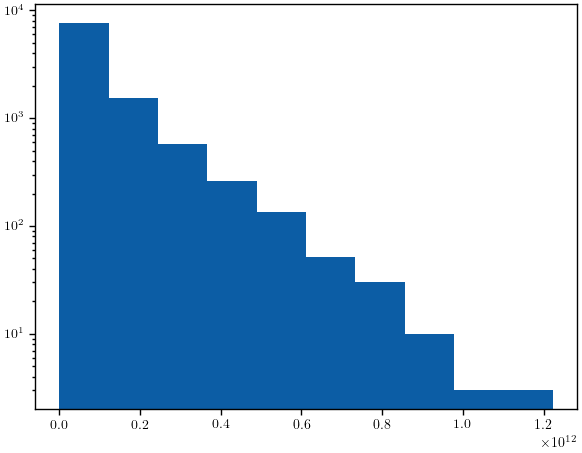

In [8]:
stellar_masses = [l.lens_stellar_mass for l in lens_list]

plt.hist(stellar_masses)
plt.yscale('log')
plt.show()

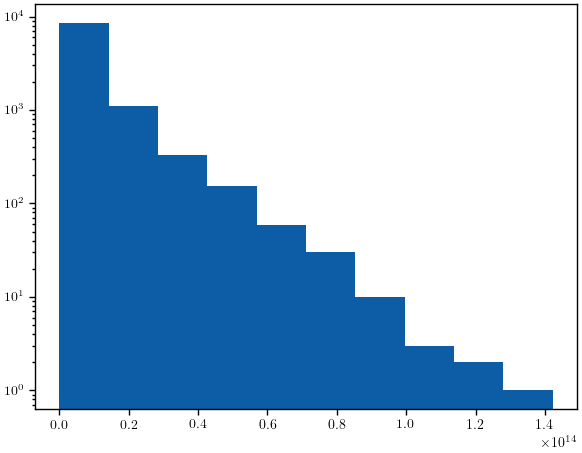

In [20]:
main_halo_masses = [l.lens_stellar_mass * 51 * (1 + l.z_lens) ** 0.9 for l in lens_list]

plt.hist(main_halo_masses)
plt.yscale('log')
plt.show()

$$\frac{M_{\mathrm{vir}}(z)}{M_{*}(z)} = (51 \pm 36)(1 + z)^{(0.9 \pm 1.8)}$$

In [19]:
from scipy.stats import truncnorm

rv1 = truncnorm(a=-1, b=1, loc=51, scale=36)
rv2 = truncnorm(a=-1, b=1, loc=0.9, scale=1.8)

rv1_dist = rv1.rvs(size=1000)
rv2_dist = rv2.rvs(size=1000)
main_halo_masses_dist = [l.lens_stellar_mass * rv1.rvs() * (1 + l.z_lens) ** rv2.rvs() for l in lens_list]

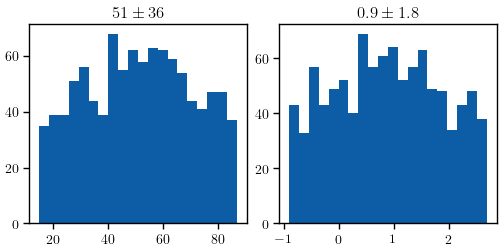

In [24]:
_, ax = plt.subplots(1, 2, figsize=(5, 2.5), constrained_layout=True)

ax[0].hist(rv1_dist, bins=20)
ax[1].hist(rv2_dist, bins=20)

ax[0].set_title(r'$51\pm36$')
ax[1].set_title(r'$0.9\pm1.8$')

plt.show()

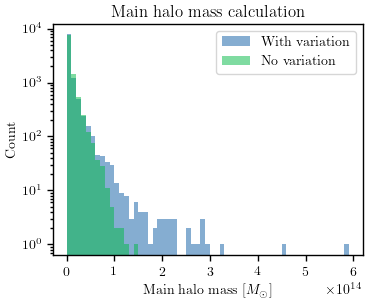

In [38]:
binwidth = 1e13
bins = np.arange(min(main_halo_masses + main_halo_masses_dist),
                 max(main_halo_masses + main_halo_masses_dist) + (binwidth / 2), binwidth)

plt.figure(figsize=(4, 3))
plt.hist(main_halo_masses_dist, label='With variation', alpha=0.5, bins=bins)
plt.hist(main_halo_masses, label='No variation', alpha=0.5, bins=bins)
plt.yscale('log')
plt.xlabel('Main halo mass [$M_\odot$]')
plt.ylabel('Count')
plt.legend()
plt.title('Main halo mass calculation')
plt.show()